# Bjet scale factors and uncertainties

Bjet inefficiency scale factors were used to rescale monte carlo events that held bjets that failed the csv(combined secondary vertex) cut. The scale factors were given by https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation53XReReco . The inefficiency scale factor was defined as: 

$$
\frac {1 - SF * \epsilon_{MC}}  {1 - \epsilon_{MC}}
$$

The uncertainty was calculated by adding quadraticly the errors given and statistical uncertainty in determining the monte carlo inefficiency.  

In [2]:
run ../prep_ana.py

Loading plotting specs...
8 or 13 TeV:8TeV
unc_mc_process and scales as dictionaries
Load MC and Data?False
df = pd.concat([df_dy0, df_dy1, df_dy2, df_dy3, df_dy4, df_dy_m_10, df_ww, df_tt_l, df_tt_sl, df_zz_ln, df_wz_ln, df_wz_lq ])


In [3]:
%matplotlib inline

In [4]:
columns=['jet1_pt', 'jet2_pt', 'jet3_pt', 'jet4_pt', 'jet5_pt', 'jet6_pt',
         'jet1_csv', 'jet2_csv', 'jet3_csv', 'jet4_csv', 'jet5_csv', 'jet6_csv',
         'jet1_flv', 'jet2_flv', 'jet3_flv', 'jet4_flv', 'jet5_flv', 'jet6_flv',
         'numb_jets', 'numb_BJet_gen', 'numb_BJet', 'bjet_unc', 'bjet_weight']


df_tt_l = rp.read_root(data_path+"/ttbar_leptonic_complete.root", columns=columns)
df_tt_sl = rp.read_root(data_path+"/ttbar_semileptonic_complete.root", columns=columns)
df_tbar_tw = rp.read_root(data_path+"/tbar_tw-_complete.root", columns=columns)
df_tbar_s = rp.read_root(data_path+"/tbar_s-_complete.root", columns=columns)
df_tbar_t = rp.read_root(data_path+"/tbar_t-_complete.root", columns=columns)
df_t_tw = rp.read_root(data_path+"/t_tw-_complete.root", columns=columns)
df_t_s = rp.read_root(data_path+"/t_s-_complete.root", columns=columns)
df_t_t = rp.read_root(data_path+"/t_t-_complete.root", columns=columns)



df = pd.concat([df_tt_l, df_tt_sl, df_tbar_s, df_tbar_t, df_tbar_tw, df_t_s, df_t_t, df_t_tw])

## Scale Factors and Efficiencies

### Scale factors
The scale factor is given via a formula fit to data. We apply a tight cut to the csv so we use the following formula:

$$
SF = (0.927563 + 1.55479e^{-05}pt )+(-1.90666e^{-07}pt^{2})
$$

It should be noted that the scale factor and efficiencies are determined in bins of pt. 

### MC Efficiency

To detimine the efficiency, &epsilon;<sub>MC</sub>  of in the monte carlo we look at top samples and select events that have some b jet, as defined by monte carlo truth and then determine how many survive the csv selection cut. 



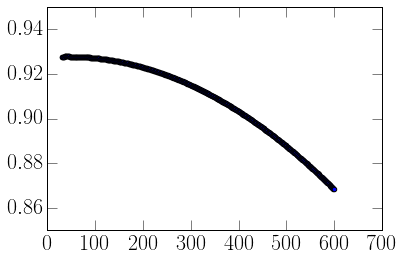

In [12]:
x = [i for i in xrange(30,600)]
y = [(0.927563+(1.55479e-05*i))+(-1.90666e-07*(i*i)) for i in x]

plt.scatter(x, y)

In [55]:
ptmin = [30, 40, 50, 60, 70, 80, 100, 120, 160, 210, 260, 320, 400, 500, 600]
ptmax = [40, 50, 60, 70, 80,100, 120, 160, 210, 260, 320, 400, 500, 600, 800]

true_bjet = []
csv_bjet = []
for i in range(len(ptmin)):
    ptmin_str = str(ptmin[i])
    ptmax_str = str(ptmax[i])
    selection_true_str = "(numb_jets == 1) & (jet1_pt > " + ptmin_str + ") & (jet1_pt < " + ptmax_str +") & (numb_BJet_gen == 1) "
    selection_csv_str = selection_true_str + "& (numb_BJet == 1)"
    true_bjet.append(df.query(selection_true_str).shape[0])
    csv_bjet.append(df.query(selection_csv_str).shape[0]) 

true_bjet = np.array(true_bjet, dtype=np.float64)
csv_bjet = np.array(csv_bjet, dtype=np.float64)

eff_MCbjet = csv_bjet / true_bjet

In [56]:
# Determine Data eff
eff_Dabjet = []
for i in range(len(ptmin)):
    pt = (ptmin[i] + ptmax[i]) / 2.
    csvt = lambda x: (0.927563+(1.55479e-05*x))+(-1.90666e-07*(x*x))
    eff_Dabjet.append( csvt(pt) * eff_MCbjet[i])
eff_Dabjet = np.array(eff_Dabjet)


In [16]:
#Calc 1 - effs 
(1 - eff_Dabjet) / (1 - eff_MCbjet)

array([ 1.04680102,  1.06055302,  1.07092639,  1.07831271,  1.08537564,
        1.08348516,  1.0896697 ,  1.08729525,  1.06247569,  1.05388583,
        1.04283063,  1.03386823,  1.01734172,  1.04052071,  1.0774899 ])

<Container object of 3 artists>

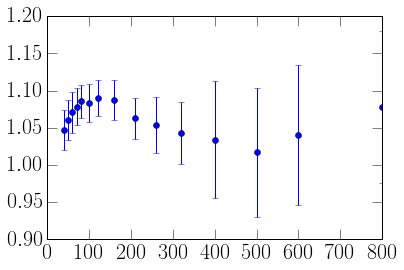

In [60]:
plt.errorbar(ptmax, (1 - eff_Dabjet) / (1 - eff_MCbjet),[0.0264008, 0.0272757, 0.0275565, 0.0248745, 0.0218456, 0.0253845, 0.0239588, 0.0271791, 0.0273912,
      0.0379822, 0.0411624, 0.0786307, 0.0866832, 0.0942053, 0.102403], fmt='o')

## Uncertainties

We calculate the uncertainties by throwing events and apply the in errors and statistical uncertaintes to the scale factors and monte carlo efficiencies then recalculating the ineffiences. 

In [11]:
csv_bjet = np.array( [0] + list(csv_bjet) )

(3165, 7)

In [62]:
def bjet_unc_toy(df = df[(df.numb_BJet_gen > 0) ]):
    #Input df[(df.numb_BJet_gen > 0) ]
    jet_csv_mask = [ df.jet1_csv < .898,
                 df.jet2_csv < .898,
                 df.jet3_csv < .898,
                 df.jet4_csv < .898,
                 df.jet5_csv < .898,
                 df.jet6_csv < .898]
    mc_eff = np.array([0.39352592,  0.45639609,  0.49569403,  0.52019587,
                0.54131472,  0.53493069,  0.55112341,  0.5412229 ,  0.45088661,
                0.40455251,  0.33779762,  0.27004219,  0.14285714,  0.25,
                0.33333333])

    bjet_unc = [0.0264008, 0.0272757, 0.0275565, 0.0248745, 0.0218456, 0.0253845, 0.0239588, 0.0271791, 0.0273912,
      0.0379822, 0.0411624, 0.0786307, 0.0866832, 0.0942053, 0.102403]
    bjet_mc_eff_unc = [0.00293578,  0.00300052,  0.00313995,  0.00336466,  0.00366717,
        0.00295177,  0.00375747,  0.00411746,  0.00725174,  0.01446677,
        0.02242042,  0.03375527,  0.05050763,  0.1118034 ,  0.23570226]#np.sqrt(csv_bjet) / true_bjet
    
    ptmin = [30, 40, 50, 60, 70, 80, 100, 120, 160, 210, 260, 320, 400, 500, 600]
    ptmax = [40, 50, 60, 70, 80,100, 120, 160, 210, 260, 320, 400, 500, 600, 800]

    bjet_iw = np.ones(df.shape[0])
    for i in xrange(len(ptmin)):
        #roll the dice
        offset_unc = np.random.normal(0,bjet_unc[i])
        offset_mc_eff = np.random.normal(0,bjet_mc_eff_unc[i])
        #loop over jets
        for jet_iter in range(1,7):
            jet_interest= 'jet'+str(jet_iter)
            
            jet_pt_mask = ( df[jet_interest+'_pt'] > ptmin[i] ) & ( df[jet_interest+'_pt'] < ptmax[i] )
            mc_eff_ = mc_eff[i] + offset_mc_eff
            
            csvt = lambda x: (0.927563+(1.55479e-05*x))+(-1.90666e-07*(x*x))
            w = csvt(df[ jet_csv_mask[jet_iter-1] & jet_pt_mask ][jet_interest+'_pt'].values) + offset_unc
            bjet_iw[ jet_csv_mask[jet_iter-1] & jet_pt_mask ] *= (1 - w*mc_eff_) / (1 - mc_eff_)
            #You'll need check the number of
    return bjet_iw

In [63]:
a = bjet_unc_toy()

In [64]:
toy_set = []
for i in xrange(100):
    toy_set.append(bjet_unc_toy())
toy_set = np.array(toy_set) 

In [65]:
#Results
toy_set.mean(1).std()

0.015396849230169535

(array([  2.,   8.,  10.,  17.,  20.,  18.,  12.,   9.,   3.,   1.]),
 array([ 1.08578406,  1.09285817,  1.09993228,  1.10700639,  1.1140805 ,
         1.12115461,  1.12822872,  1.13530283,  1.14237694,  1.14945105,
         1.15652516]),
 <a list of 10 Patch objects>)

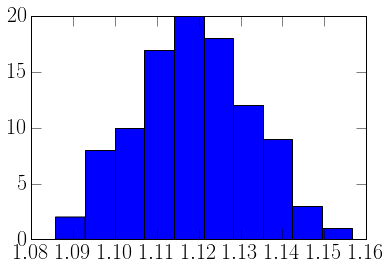

In [47]:
plt.hist(toy_set.mean(1))

### Inefficiency uncertainty 

The uncertainty of 0.015.

Applyed to the cross-section we approximately get:
$$
60. / 6000.  * .015 = 0.00015
$$
60 ~ cross-section <br>
6000 ~ N<sub>Data</sub> - N<sub>Bkg</sub>

In [61]:
np.sqrt(csv_bjet) / true_bjet

array([ 0.00293578,  0.00300052,  0.00313995,  0.00336466,  0.00366717,
        0.00295177,  0.00375747,  0.00411746,  0.00725174,  0.01446677,
        0.02242042,  0.03375527,  0.05050763,  0.1118034 ,  0.23570226])